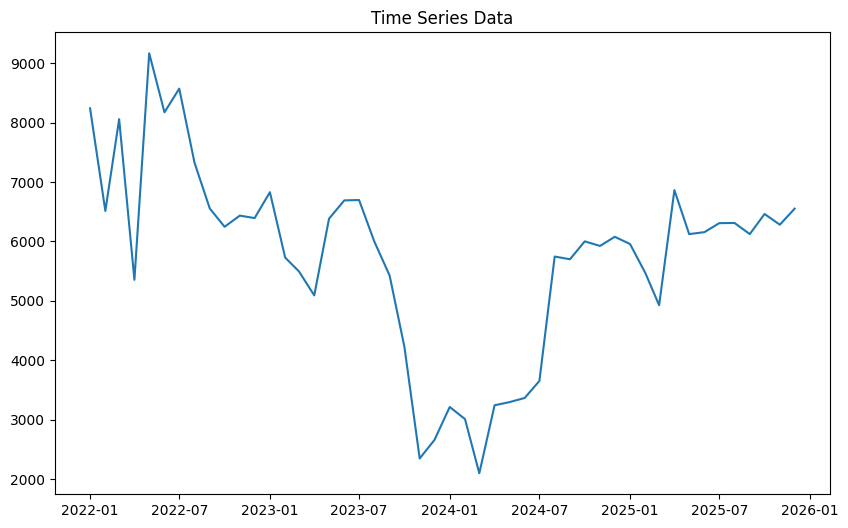


Stationarity Test:
ADF Statistic: -2.5938714427119396
p-value: 0.09427054273453661
The series is not stationary.

Addressing Non-Stationarity:
Applying Differencing...

Testing stationarity after differencing:
ADF Statistic: -10.494083157602208
p-value: 1.127299715560681e-18
The series is stationary.


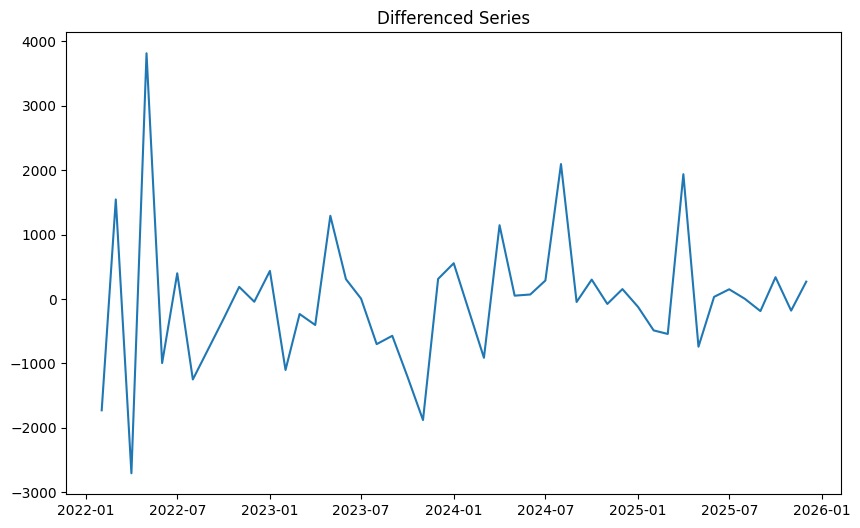

Applying Log Transformation...

Testing stationarity after log transformation:
ADF Statistic: -2.251059999549111
p-value: 0.18823792937397293
The series is not stationary.


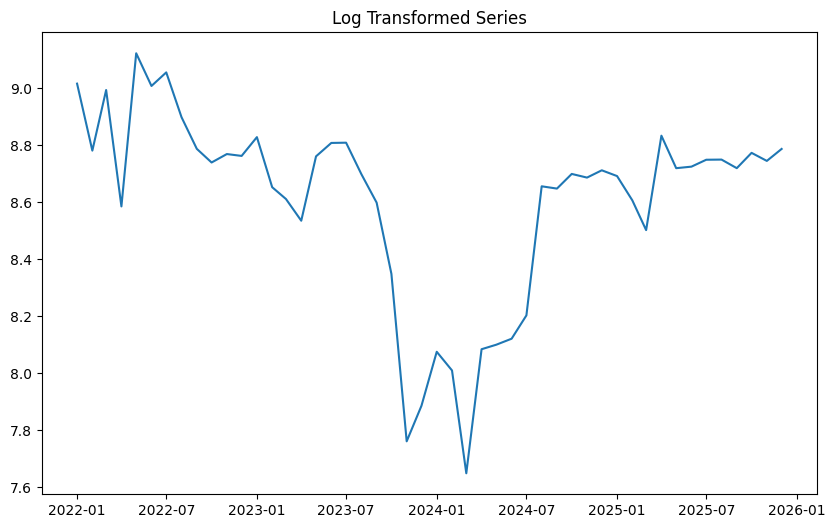

Differencing achieved stationarity.

Seasonal Decomposition:


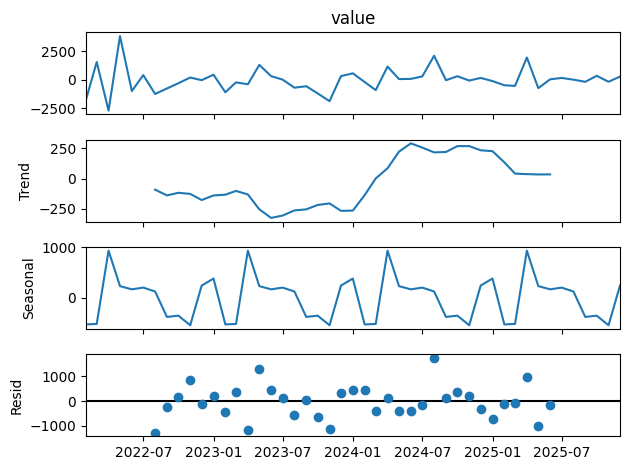


ACF and PACF:


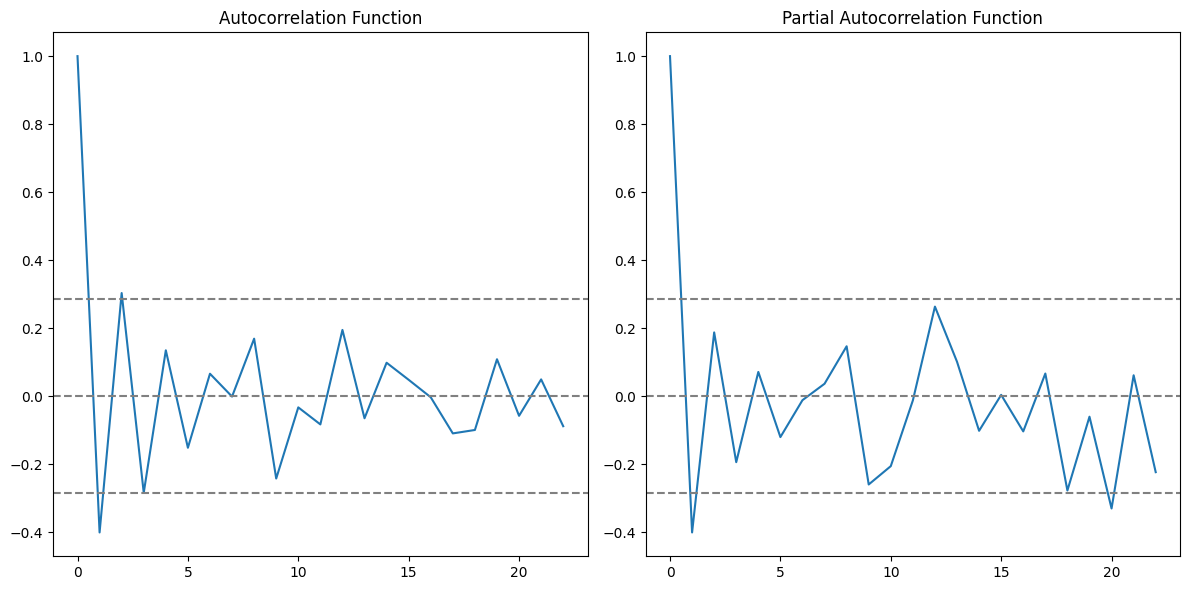

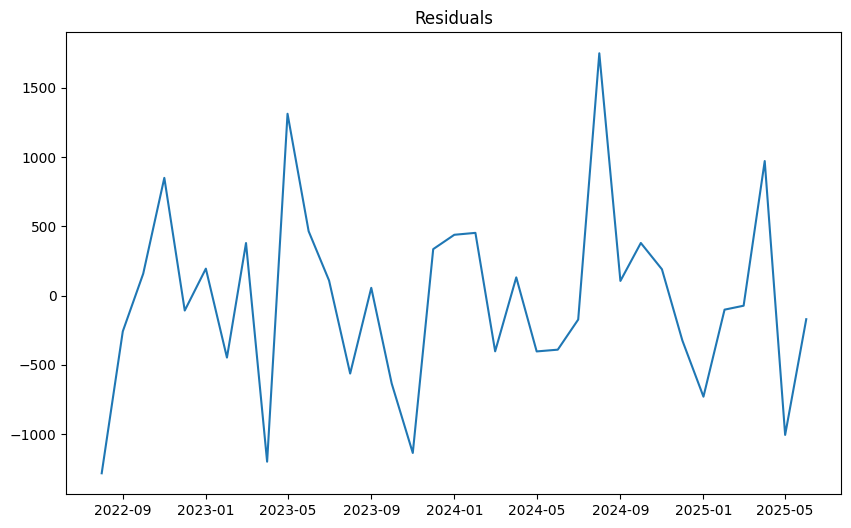


Analyzing residuals for anomalies:
Detected 1 anomalies:
Date
2024-08-01    1750.217024
Name: resid, dtype: float64


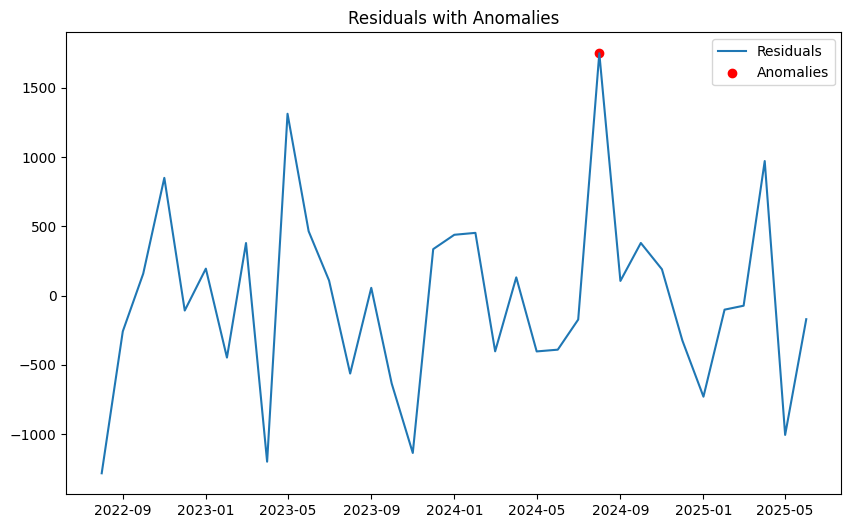

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler

# Function to check stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
        return True, result[0]
    else:
        print("The series is not stationary.")
        return False, result[0]

# Function to perform seasonal decomposition
def perform_decomposition(timeseries, frequency):
    decomposition = seasonal_decompose(timeseries, model='additive', period=frequency)
    decomposition.plot()
    plt.show()
    return decomposition

# Function to compute ACF and PACF dynamically
def plot_acf_pacf_dynamic(timeseries):
    lags = min(len(timeseries) // 2 - 1, 40)  # Dynamic lag adjustment
    lag_acf = acf(timeseries, nlags=lags)
    lag_pacf = pacf(timeseries, nlags=lags, method='ols')

    plt.figure(figsize=(12, 6))

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.title('Autocorrelation Function')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.axhline(y=-1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
    plt.title('Partial Autocorrelation Function')

    plt.tight_layout()
    plt.show()

# Function to apply differencing

def apply_differencing_refined(timeseries):
    try:
        differenced_series = timeseries.diff().dropna()
        print("\nTesting stationarity after differencing:")
        is_stationary, adf_stat = test_stationarity(differenced_series)
        plt.figure(figsize=(10, 6))
        plt.plot(differenced_series)
        plt.title('Differenced Series')
        plt.show()
        return differenced_series, is_stationary, adf_stat
    except Exception as e:
        print(f"Error in applying differencing: {e}")
        return timeseries, False, None

# Function to apply log transformation
def apply_log_transformation(timeseries):
    log_transformed = np.log(timeseries.replace(0, np.nan)).dropna()
    print("\nTesting stationarity after log transformation:")
    is_stationary, adf_stat = test_stationarity(log_transformed)
    plt.figure(figsize=(10, 6))
    plt.plot(log_transformed)
    plt.title('Log Transformed Series')
    plt.show()
    return log_transformed, is_stationary, adf_stat

# Function to analyze anomalies in residuals
def analyze_anomalies(residuals):
    threshold = 2 * residuals.std()
    anomalies = residuals[abs(residuals) > threshold]
    if not anomalies.empty:
        print(f"Detected {len(anomalies)} anomalies:")
        print(anomalies)
    else:
        print("No significant anomalies detected.")
    
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals')
    plt.scatter(anomalies.index, anomalies, color='red', label='Anomalies')
    plt.title('Residuals with Anomalies')
    plt.legend()
    plt.show()

# Main function for time series analysis
def time_series_analysis(data, date_column, value_column, frequency):
    # Ensure data is sorted
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.sort_values(by=date_column)
    data.set_index(date_column, inplace=True)

    # Handle missing values
    if data[value_column].isnull().sum() > 0:
        print("Missing values detected. Filling missing values with forward fill.")
        data[value_column].fillna(method='ffill', inplace=True)

    timeseries = data[value_column]

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.title('Time Series Data')
    plt.show()

    # Check stationarity
    print("\nStationarity Test:")
    is_stationary, _ = test_stationarity(timeseries)

    if not is_stationary:
        print("\nAddressing Non-Stationarity:")
        print("Applying Differencing...")
        differenced_series, diff_stationary, diff_adf_stat = apply_differencing_refined(timeseries)

        print("Applying Log Transformation...")
        log_transformed_series, log_stationary, log_adf_stat = apply_log_transformation(timeseries)

        if diff_stationary and log_stationary:
            if diff_adf_stat < log_adf_stat:
                print("Differencing showed a stronger impact (lower ADF Statistic). Selecting differencing.")
                timeseries = differenced_series
            else:
                print("Log transformation showed a stronger impact (lower ADF Statistic). Selecting log transformation.")
                timeseries = log_transformed_series
        elif diff_stationary:
            print("Differencing achieved stationarity.")
            timeseries = differenced_series
        elif log_stationary:
            print("Log transformation achieved stationarity.")
            timeseries = log_transformed_series
        else:
            print("Neither method achieved perfect stationarity. Proceeding with differencing as a fallback.")
            timeseries = differenced_series

    # Perform seasonal decomposition
    print("\nSeasonal Decomposition:")
    decomposition = perform_decomposition(timeseries, frequency)

    # Plot ACF and PACF dynamically
    print("\nACF and PACF:")
    plot_acf_pacf_dynamic(timeseries)

    # Analyze residuals for anomalies
    residuals = decomposition.resid.dropna()
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.show()

    print("\nAnalyzing residuals for anomalies:")
    analyze_anomalies(residuals)

    return {
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid
    }

data = pd.read_csv('D:\Fintech\Scenarios\id_S275848.csv')
data['Date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
result = time_series_analysis(data, 'Date' , 'value', frequency=12)

FORECASTING

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

def time_series_forecast(data, date_column, target_column, frequency, steps):
    """
    Perform time series analysis and forecasting using SARIMA and Holt-Winters models.

    Parameters:
        data (pd.DataFrame): Input dataset with date and target columns.
        date_column (str): Name of the date column.
        target_column (str): Name of the target column.
        frequency (int): Seasonal frequency (e.g., 12 for monthly data).
        steps (int): Number of steps to forecast.

    Returns:
        dict: Dictionary containing RMSE values and plots of forecasts.
    """
    # Preprocess the dataset
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.sort_values(by=date_column)
    data.set_index(date_column, inplace=True)

    # Function to check stationarity using ADF test
    def test_stationarity(timeseries):
        result = adfuller(timeseries, autolag='AIC')
        print("ADF Statistic:", result[0])
        print("p-value:", result[1])
        if result[1] <= 0.05:
            print("The series is stationary.")
            return True, result[0]
        else:
            print("The series is not stationary.")
            return False, result[0]

    # Function to perform seasonal decomposition
    def perform_decomposition(timeseries, frequency):
        decomposition = seasonal_decompose(timeseries, model='additive', period=frequency)
        decomposition.plot()
        plt.show()
        return decomposition

    # Function to plot ACF and PACF
    def plot_acf_pacf_dynamic(timeseries):
        lags = min(len(timeseries) // 2 - 1, 40)  # Dynamic lag adjustment
        lag_acf = acf(timeseries, nlags=lags)
        lag_pacf = pacf(timeseries, nlags=lags, method='ols')

        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.plot(lag_acf)
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.axhline(y=1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
        plt.axhline(y=-1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
        plt.title('Autocorrelation Function')

        plt.subplot(122)
        plt.plot(lag_pacf)
        plt.axhline(y=0, linestyle='--', color='gray')
        plt.axhline(y=1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
        plt.axhline(y=-1.96 / np.sqrt(len(timeseries)), linestyle='--', color='gray')
        plt.title('Partial Autocorrelation Function')

        plt.tight_layout()
        plt.show()

    # Function to apply differencing
    def apply_differencing_refined(timeseries):
        differenced_series = timeseries.diff().dropna()
        print("\nTesting stationarity after differencing:")
        is_stationary, adf_stat = test_stationarity(differenced_series)
        plt.figure(figsize=(10, 6))
        plt.plot(differenced_series)
        plt.title('Differenced Series')
        plt.show()
        return differenced_series, is_stationary, adf_stat

    # Function to apply log transformation
    def apply_log_transformation(timeseries):
        log_transformed = np.log(timeseries.replace(0, np.nan)).dropna()
        print("\nTesting stationarity after log transformation:")
        is_stationary, adf_stat = test_stationarity(log_transformed)
        plt.figure(figsize=(10, 6))
        plt.plot(log_transformed)
        plt.title('Log Transformed Series')
        plt.show()
        return log_transformed, is_stationary, adf_stat

    # Function for time series analysis
    def time_series_analysis(data, value_column, frequency):
        timeseries = data[value_column]

        plt.figure(figsize=(10, 6))
        plt.plot(timeseries)
        plt.title('Time Series Data')
        plt.show()

        print("\nStationarity Test:")
        is_stationary, _ = test_stationarity(timeseries)

        if not is_stationary:
            print("\nAddressing Non-Stationarity:")
            differenced_series, diff_stationary, diff_adf_stat = apply_differencing_refined(timeseries)
            log_transformed_series, log_stationary, log_adf_stat = apply_log_transformation(timeseries)

            if diff_stationary and log_stationary:
                if diff_adf_stat < log_adf_stat:
                    print("Differencing showed a stronger impact. Selecting differencing.")
                    timeseries = differenced_series
                else:
                    print("Log transformation showed a stronger impact. Selecting log transformation.")
                    timeseries = log_transformed_series
            elif diff_stationary:
                print("Differencing achieved stationarity.")
                timeseries = differenced_series
            elif log_stationary:
                print("Log transformation achieved stationarity.")
                timeseries = log_transformed_series
            else:
                print("Neither method achieved perfect stationarity. Proceeding with differencing.")
                timeseries = differenced_series

        print("\nSeasonal Decomposition:")
        perform_decomposition(timeseries, frequency)

        print("\nACF and PACF:")
        plot_acf_pacf_dynamic(timeseries)

        return timeseries

    # Analyze the time series
    processed_series = time_series_analysis(data, value_column=target_column, frequency=frequency)
    # Determine AR and MA orders for SARIMA
    def find_p_q_acf_pacf(timeseries, lags=20):
        lag_acf = acf(timeseries, nlags=lags)
        lag_pacf = pacf(timeseries, nlags=lags, method='ols')
        p = next((i for i, x in enumerate(lag_pacf) if abs(x) < 1.96 / np.sqrt(len(timeseries))), 1)
        q = next((i for i, x in enumerate(lag_acf) if abs(x) < 1.96 / np.sqrt(len(timeseries))), 1)
        return p, q

    p, q = find_p_q_acf_pacf(processed_series)
    P, Q = find_p_q_acf_pacf(processed_series, lags=frequency)

    # Fit SARIMA model
    sarima_model = SARIMAX(data[target_column], order=(p, 1, q), seasonal_order=(P, 1, Q, frequency))
    sarima_fitted = sarima_model.fit(disp=False)
    sarima_forecast = sarima_fitted.get_forecast(steps=steps).predicted_mean

    # Fit Holt-Winters model
    holt_model = ExponentialSmoothing(
        data[target_column],
        seasonal_periods=frequency,
        trend='add',
        seasonal='add',
        damped_trend=True
    ).fit()
    holt_forecast = holt_model.forecast(steps=steps)

    # Calculate RMSE for both models
    sarima_rmse = sqrt(mean_squared_error(data[target_column][-steps:], sarima_forecast[:steps]))
    holt_rmse = sqrt(mean_squared_error(data[target_column][-steps:], holt_forecast[:steps]))

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(data[target_column], label='Original Data', color='blue')
    plt.plot(sarima_forecast, label=f'SARIMA Forecast (RMSE={sarima_rmse:.2f})', color='purple')
    plt.plot(holt_forecast, label=f'Holt-Winters Forecast (RMSE={holt_rmse:.2f})', color='green')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

    # Return results
    return {
        "SARIMA_RMSE": sarima_rmse,
        "Holt_Winters_RMSE": holt_rmse,
        "SARIMA_Forecast": sarima_forecast,
        "Holt_Winters_Forecast": holt_forecast
    }

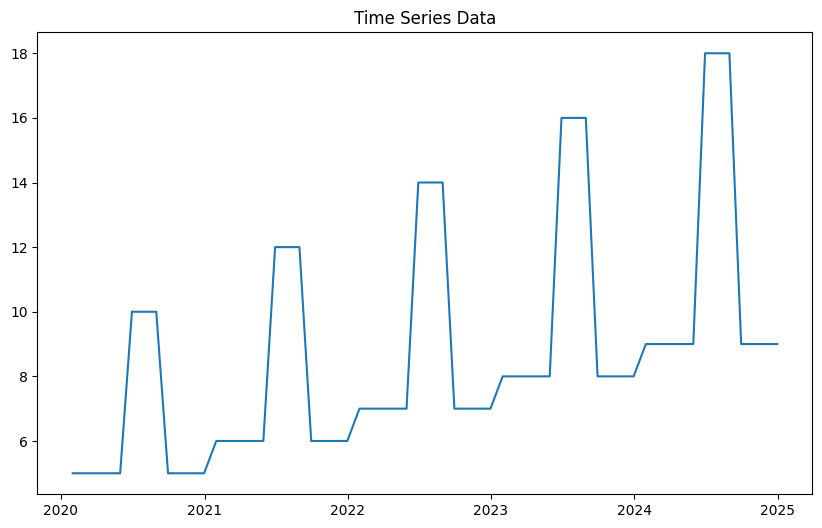


Stationarity Test:
ADF Statistic: -0.0022646678881991546
p-value: 0.9583443984181917
The series is not stationary.

Addressing Non-Stationarity:

Testing stationarity after differencing:
ADF Statistic: -3.1877358135801535
p-value: 0.02070564446074131
The series is stationary.


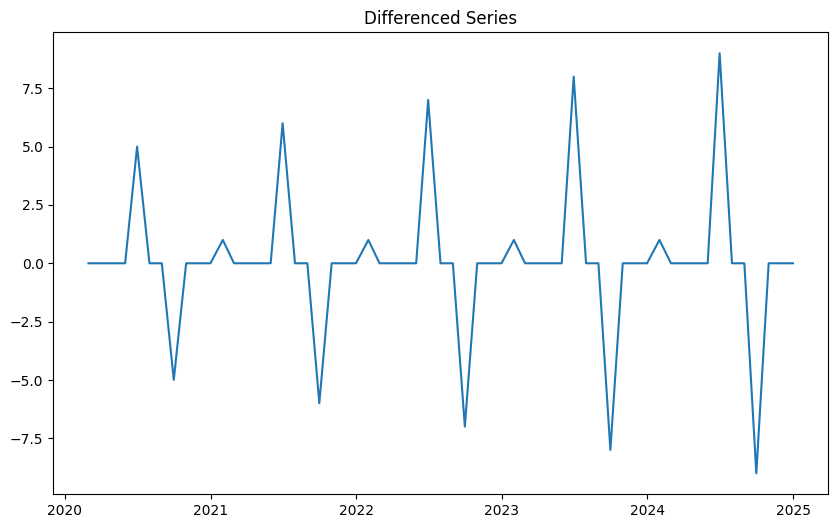


Testing stationarity after log transformation:
ADF Statistic: -76.74511519019246
p-value: 0.0
The series is stationary.


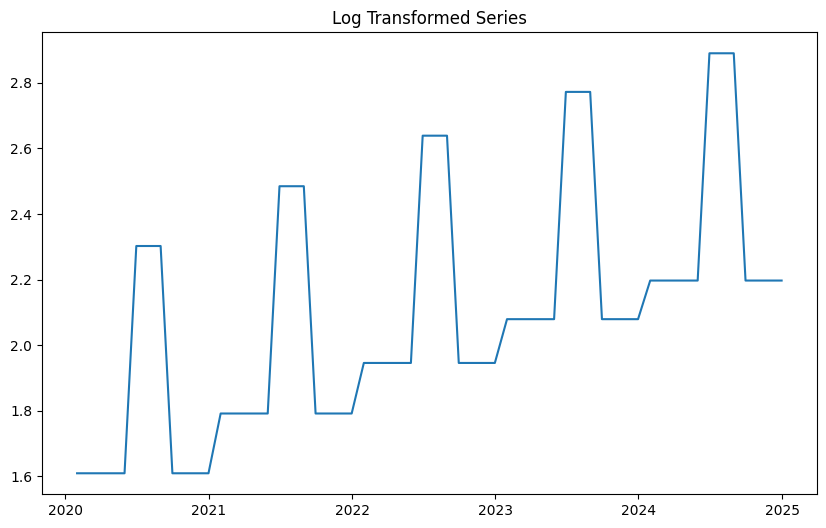

Log transformation showed a stronger impact. Selecting log transformation.

Seasonal Decomposition:


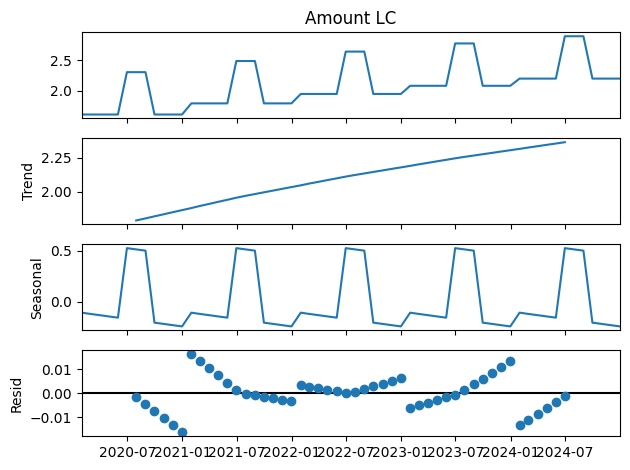


ACF and PACF:


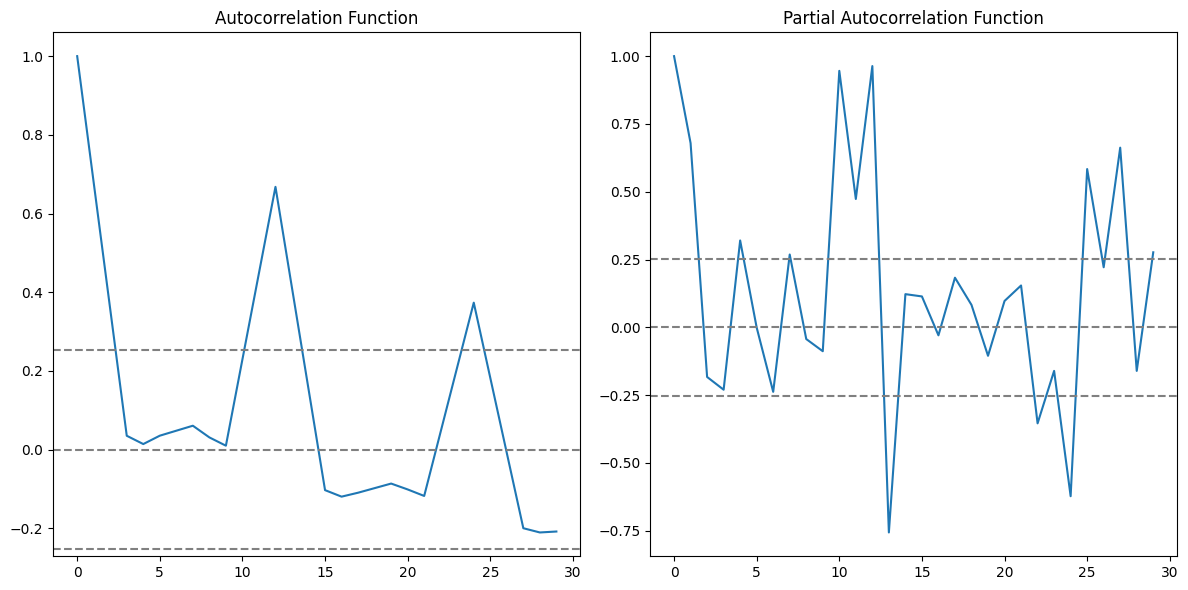

d:\Fintech\Scenarios\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Fintech\Scenarios\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Fintech\Scenarios\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Fintech\Scenarios\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\Fintech\Scenarios\.venv\lib\site-packages\statsmo

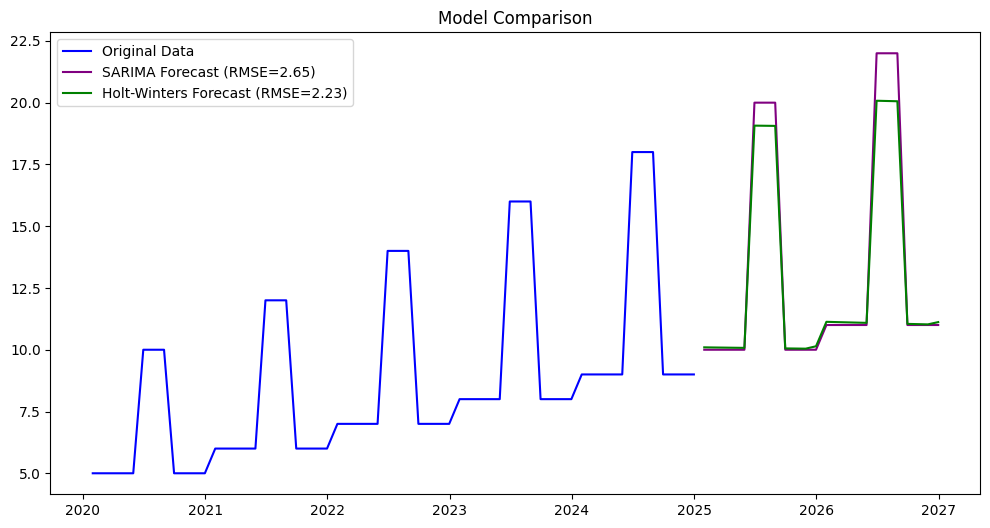

{'SARIMA_RMSE': 2.645476699279555,
 'Holt_Winters_RMSE': 2.2275032128508916,
 'SARIMA_Forecast': 2025-01-31    10.000000
 2025-02-28    10.000000
 2025-03-31    10.000134
 2025-04-30    10.000134
 2025-05-31    10.000134
 2025-06-30    19.999558
 2025-07-31    19.999558
 2025-08-31    19.999558
 2025-09-30    10.000134
 2025-10-31    10.000134
 2025-11-30    10.000134
 2025-12-31    10.000087
 2026-01-31    11.000088
 2026-02-28    11.000087
 2026-03-31    11.000550
 2026-04-30    11.000550
 2026-05-31    11.000550
 2026-06-30    21.998190
 2026-07-31    21.998190
 2026-08-31    21.998190
 2026-09-30    11.000550
 2026-10-31    11.000550
 2026-11-30    11.000550
 2026-12-31    11.000418
 Freq: ME, Name: predicted_mean, dtype: float64,
 'Holt_Winters_Forecast': 2025-01-31    10.097012
 2025-02-28    10.091527
 2025-03-31    10.086069
 2025-04-30    10.080639
 2025-05-31    10.075236
 2025-06-30    19.069859
 2025-07-31    19.064510
 2025-08-31    19.059187
 2025-09-30    10.053892
 2025

In [139]:
# Load the dataset
file_path = 'D:\Fintech\Scenarios\scenario_1_seasonality_3_months_rest_normal.csv'
data = pd.read_csv(file_path)
# data['Date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(by='Date')
time_series_forecast(data,"Date","Amount LC",12,24)